# Introduction

This tutorial will introduce you to some basic methods for processing Yelp data from [Yelp Data Challenge](https://www.yelp.com/dataset/challenge), particularly focusing on sentimental analysis on yelp data. We will predict yelp star-rating of a review based on the text review of the customer.

For example, if the review is "Food was very delicious, Very good ambience." the rating is expected to be 5-star. If the review is "very bad food, horrible taste." the rating is expected to be 1-star.



## Tutorial Content
In this tutorial, we will learn how to implement supervised machine learning on yelp review texts to predict star-ratings of the reviews. We will be using scikit-learn python library to do the same.

We will cover the following topics in this tutorial:
- [Installing Libraries](#Installing-Libraries)
- [Loading Data](#Loading-Data)
- [Balancing Data](#Balancing-Data)
- [Converting Text to TF-IDF Vectors](#Converting-Text-to-TF-IDF-Vectors)
- [Splitting Data into Train and Test](#Splitting-Data-into-Train-and-Test)
- [Train Text Data using Support Vector Machine(SVM) ](#Train-Text-Data-using-Support-Vector-Machine(SVM)
- [Predict Data ](#Predict-Data)
- [Evaluate Classifier ](#Evaluate-Classifier)
- [Positive or Negative Classification](#Positive-or-Negative-Classification)
- [Conclusion](#Conclusion)




## Installing Libraries
Before getting started, you will have to install scikit-learn using pip:

    $ pip install -U scikit-learn

or using conda:

    $ conda install scikit-learn

You can get more information about installing scikit-learn library [here](http://scikit-learn.org/stable/install.html)

After you install the libraries, make sure the following imports work correctly:

In [288]:
import pandas as pd
import json
from collections import Counter
from matplotlib import pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


These are the versions of the libraries We will be using:

In [289]:
print("pandas version",pd.__version__)
print("json version",json.__version__)
print("numpy version",np.__version__)


pandas version 0.18.1
json version 2.0.9
numpy version 1.13.3


## Loading Data
Firstly, we will download yelp data from [Yelp Data Challenge](https://www.yelp.com/dataset/challenge). Click on "Download Dataset", fill the form and click "Download".

You will have 3 options of downloading formats: JSON, SQL, Photos.
Download the Json format by clicking on "Download JSON" and untar the downloaded file.

From the downloaded files, we need "review.json" for our analysis. We will be analysing first 50000 reviews from review.json 



Store reviews text to list named "text" and ratings to list named "stars".

In [290]:
# get first 50000 reviews from review.json
with open("review.json") as f:
    head = [json.loads(next(f)) for x in range(50000)]
stars=[]
text = []
# store review text and rating in text and stars lists respectively
for review in head:
    stars.append(review["stars"])
    text.append(review["text"])

        

Let us check out the total number of reviews for each star-rating by using Counter.

In [291]:
star_counts=Counter(stars)
print(star_counts)

Counter({5: 20187, 4: 12876, 3: 6527, 1: 6263, 2: 4147})


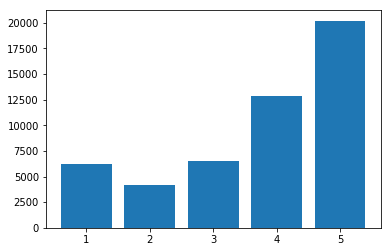

In [292]:
# plot bar graph between number of reviews and ratings

lists = sorted(star_counts.items()) 

x, y = zip(*lists) 

plt.bar(x, y)
plt.show()

As we can see, there are 20187 reviews with 5-star rating and just 4147 reviews with 2-star rating. This is an imbalanced data.



# Balancing Data

In machine learning classifiers, results will be biased if the input data is imbalanced.

We will now reduce our dataset to the number of reviews with the rating which has the minimum number of reviews. In this case, 2-star rating has the minimum number of reviews i.e 4147 reviews. This will help to balance our data and get less biased prediction from our machine learning algorithm.

[Click here](https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/) if you want to learn more about imbalanced data problem and other methods to handle this problem.


In [293]:
def balance(text, stars):
    freq = Counter(stars)
    # find minimum number of reviews
    min_rev = freq.most_common()[-1][1]
    print("minimum number of reviews:", min_rev)
    
    dic={}
    for k in freq.keys():
        dic[k] = 0
    
    new_stars = []
    new_text = []
    for i, s in enumerate(stars):
        if dic[s] < min_rev:
            new_stars.append(s)
            new_text.append(text[i])
            dic[s] = dic[s] + 1
    return new_text, new_stars
    

In [294]:
print(Counter(stars))
balanced_x, balanced_y = balance(text, stars)
print(Counter(balanced_y))

Counter({5: 20187, 4: 12876, 3: 6527, 1: 6263, 2: 4147})
minimum number of reviews: 4147
Counter({5: 4147, 4: 4147, 3: 4147, 1: 4147, 2: 4147})


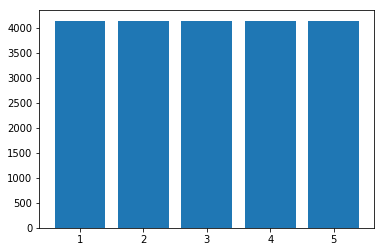

In [295]:
# plot bar graph between number of reviews and ratings
star_counts = Counter(balanced_y)
lists = sorted(star_counts.items()) 

x, y = zip(*lists) 

plt.bar(x, y)
plt.show()

Now we have a balanced data set and we can work on vectorizing the data

## Converting Text to TF-IDF Vectors 

Now we will convert our text into vectors so that it is understood by our machine learning algorithm. We will be constructing Term Frequency Inverse Document Frequency(TF-IDF) vectors which is one of the most sophisticated method to create vectors for Natural Language Processing. It will divide our text into frequency of words and will exclude the very common words like "of", "the" because these words are not important for the review classification. 

Words often mean different when combined with other words. We would expect our machine learning algorithm to classify words like 'amazing' as positive. 
But what will happen if the review is "The Food was not so amazing"?

Here we will be using n-gram model where text will be broken into n-grams.
e.g. "The Food was not so amazing" will be divided in bi-gram model as ("The Food","Food was","was not","not so","so amazing"). This would help to learn fine-grained meanings of the sentences in the text. As we increase the "n" in n-gram model, more processing power will be required.
We will stick to bigram model.

In [296]:

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2))
print(vectorizer)
vectors = vectorizer.fit_transform(balanced_x)
# print(vectors)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)


## Splitting Data into Train and Test

We will divide our dataset into two parts: Train and Test. For Train, both text and ratings of the reviews will be provided, but for Test, only text of reviews will be provided to our learning algorithm. We will predict the ratings of reviews using our machine learning algorithm.

In [297]:
from sklearn.cross_validation import train_test_split
# split data into test and train
X_train, X_test, y_train, y_test = train_test_split(vectors, balanced_y, test_size=0.30)


## Train Text Data using Support Vector Machine(SVM)

We will use Linear Support Vector Machine classifier for text classification.

In [298]:
from sklearn.svm import LinearSVC
print("sklearn version:",sklearn.__version__)
 
# initialise the SVM classifier
classifier = LinearSVC()
 
# train the classifier
classifier.fit(X_train, y_train)


sklearn version: 0.17.1


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Predict Data


Now we will predict our data display a small sample of data to look how close our prediction is to the actual rating. 

In [299]:
preds = classifier.predict(X_test)
print("prediction:",list(preds[:10]))
print("Actual:    ",y_test[:10])

prediction: [4, 2, 5, 1, 1, 2, 4, 1, 3, 4]
Actual:     [3, 3, 4, 1, 1, 1, 5, 1, 3, 5]


As we can see, our prediction is not perfect but it is quite good as 4 out of 10 ratings are correct. This is a good sanity check

## Evaluate Classifier

We will now evaluate our prediction classifier by calculating the accuracy of our classifier. We can calculate the accuracy of our machine learning algorithm by comparing the predicted ratings with the real ratings. If the accuracy is 1, that means our prediction was 100% correct. If accuracy is 0.8, that means our prediction is 80% correct. 

In [301]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, preds))

0.576434656808


This means that our classifier is around 56% accurate. This score is quite low.
For a given review and rating, the classifier might give false positive or false negative classification. If a classifier predicts the rating to be 5-star but it is actually below that, it is false positive classification. On the other hand, if a review is actually 5-star but the classifier classifies a review to be 5-star.

We will have a look other evaluation methods like precision and recall to evaluate our classifier.

A classifier with high precision for 5-star rating is less likely to predict other reviews to be 5-star but it might classify actual 5-star reviews to be in other class. 
On the other hand, A classifier with high recall is more likely to predict 5-star reviews correctly but it may also predict other class reviews to be 5-star reviews.

We would like to have a balance between precision and recall. For this we measure F1 score which is a combination of both precision and recall in a single metric.

In [302]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

          1       0.67      0.80      0.73      1220
          2       0.52      0.43      0.47      1244
          3       0.47      0.47      0.47      1213
          4       0.51      0.45      0.48      1275
          5       0.66      0.74      0.70      1269

avg / total       0.57      0.58      0.57      6221



We look at As we can see, 1-star and 5-star ratings have higher f1 score which means that they are easier to predict but it is more difficult to predict ratings in class {2,3,4}.

It is important for us to predict 1-star as 5-star review or vice verca.
But predicting 4-star as 5-star is not much problem and can be ignored. 

We will have a look at another evaluation metric which is Confusion Matrix.


In [303]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, preds))

[[979 178  35   9  19]
 [348 529 280  54  33]
 [ 80 247 569 244  73]
 [ 22  56 265 568 364]
 [ 28  17  52 231 941]]


The first row shows the reviews predicted as 1-star.
The first column shows the actual reviews in 1-star category.
On the first row-second column , we see that there were 229 reviews which were actually 2 star but predicted as 1-star by our classifier.
We can see that the classifier has mainly confused between subsequent ratings like 4-star or 5-star ratings, 1-star or 2-star ratings

## Positive or Negative Classification


Now we will try to classify our reviews into positive(1-2 star) or negative(4-5 star). We will remove the 3-star reviews.

We will label n for negative reviews(1-2 star reviews) and p for positive reviews(4-5 star reviews) and we will remove 3-star reviews.

In [304]:
sset = set([1,2,4,5])
 
# indices to keep
k_train = []
for i, y in enumerate(y_train):
    if y in sset:
        k_train.append(i)

k_test = []
for i, y in enumerate(y_test):
    if y in sset:
        k_test.append(i)

        
# convert the train set
X_train2 = X_train[k_train, :]
y_train2 = [y_train[i] for i in k_train]
y_train2 = ["n" if (y == 1 or y == 2) else "p" for y in y_train2]
 
# convert the test set
X_test2 = X_test[k_test, :]
y_test2 = [y_test[i] for i in k_test]
y_test2 = ["n" if (y == 1 or y == 2) else "p" for y in y_test2]

Now we can train the classifier again on new data set.

In [305]:
classifier.fit(X_train2, y_train2)
preds = classifier.predict(X_test2)
print(classification_report(y_test2, preds))
print(confusion_matrix(y_test2, preds))

             precision    recall  f1-score   support

          n       0.93      0.94      0.93      2464
          p       0.94      0.93      0.93      2544

avg / total       0.93      0.93      0.93      5008

[[2308  156]
 [ 176 2368]]


We can see that the classifier is 94% accurate which is really good accuracy. 
Confusion matrix tells that 156 negative reviews were classified as positive and 178 positive reviews were classified as negative.

## Conclusion

We covered basics of TFIDF and Support Vector Machine to classify text. We vectorized our text and train a classifier. 
We predicted the rating or the review based on the text and also predicted if the review is negative or positive.

These results from the experiments can help a restaurant to know the trend of general sentiment of the restaurant from other social media platforms like facebook or twitter. 

for example:

In [307]:
comments = ["I hated the food. Worst experience ever","I loved the food,amazing ambience"]
v = vectorizer.transform(comments)
print(classifier.predict(v))

['n' 'p']


In the above code, classifier determines that first comment was negative and second comment was positive.